# SQUANCH Demonstration
## Attenuated superdense coding down a fiber optic cable

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp

%matplotlib inline

from squanch import qstream, gates

import cProfile, re

In [3]:
fiberOpticAttenuation = -0.16  # dB/km, from Yin, et al, Satellite-based entanglement
cableLength = 1  # km, let's just call it this for now 
# Total attenuation along the fiber, equal to probability of receiving a photon
decibelLoss = cableLength * fiberOpticAttenuation
cableAttenuation = 10 ** (decibelLoss / 10)


def attenuatedSuperdenseTransmission(bit1, bit2, qStream):
    # Alice prepares a two-qubit system
    AB = qStream.pop()
    
    alice, bob = AB.qubits()

    # Prepare the bell pair
    gates.H(alice)
    AB.apply(gates._CNOT)

    # Alice sends the first qubit to Bob - if it is attenuated, return 0,0
    if np.random.rand() > cableAttenuation:
        return 0, 0

    # Alice encodes her bits
    if bit2 == 1:
        gates.X(alice)
    if bit1 == 1:
        gates.Z(alice)

    # Alice sends her qubit to bob and then he decodes the bits
    if np.random.rand() > cableAttenuation:
        return 0, 0
    AB.apply(gates._CNOT)
    gates.H(alice)

    # Measure the results
    outputBit1 = alice.measure()
    outputBit2 = bob.measure()

    return outputBit1, outputBit2

def attenuatedIntTransmission(value, qStream):
    '''Transmit an 8-bit unsigned integer value including attenuation effects'''
    bits = np.unpackbits(np.array([value], dtype=np.uint8))
    receivedBits = np.zeros(8, dtype=np.uint8)
    
    for i in range(4):
        b1, b2 = attenuatedSuperdenseTransmission(bits[2 * i], bits[2 * i + 1], qStream)
        receivedBits[2 * i] = b1
        receivedBits[2 * i + 1] = b2
        
    return np.packbits(receivedBits)[0]

def attenuatedArrayTransmission(array):
    bitsToSend = array.size * 8 * np.dtype(np.uint8).itemsize
    numQuantumSystems = bitsToSend / 2
    
    qs = qstream.QStream(2, numQuantumSystems)
    
    receivedArray = np.zeros(array.shape, dtype=np.uint8)
    iterator = np.nditer(array, flags=['multi_index'])

    while not iterator.finished:
        receivedElement = attenuatedIntTransmission(iterator[0], qs)
        receivedArray[iterator.multi_index] = receivedElement
        iterator.iternext()
    return receivedArray

Original image:


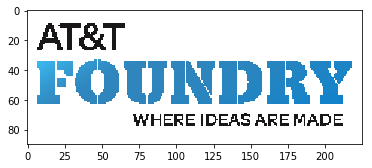

In [4]:
# Let's try transmitting the following image: 
imgData = mp.image.imread("img/foundryLogo.bmp") 
print "Original image:"
plt.imshow(imgData)

In [5]:
# Transmit the image with the attenuated superdense protocol
receivedArray = attenuatedArrayTransmission(imgData)
print "Reconstructed transmitted image accounting for attenuation effects:"
plt.imshow(receivedArray)

Reconstructed transmitted image accounting for attenuation effects:


In [6]:
test=cProfile.run("attenuatedArrayTransmission(imgData)")

         32419486 function calls in 33.448 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    81000    0.986    0.000   33.266    0.000 <ipython-input-3-8515c5db8256>:40(attenuatedIntTransmission)
        1    0.169    0.169   33.448   33.448 <ipython-input-3-8515c5db8256>:52(attenuatedArrayTransmission)
   324000    3.384    0.000   31.716    0.000 <ipython-input-3-8515c5db8256>:8(attenuatedSuperdenseTransmission)
        1    0.000    0.000   33.448   33.448 <string>:1(<module>)
        1    0.000    0.000    0.002    0.002 fromnumeric.py:357(repeat)
        1    0.000    0.000    0.002    0.002 fromnumeric.py:42(_wrapit)
        1    0.000    0.000    0.002    0.002 fromnumeric.py:55(_wrapfunc)
   624878    0.539    0.000    2.571    0.000 gates.py:28(H)
   279744    0.281    0.000    1.147    0.000 gates.py:37(X)
   280178    0.249    0.000    1.039    0.000 gates.py:45(Z)
  1184800    0.826    0.000    0.826    0.000 

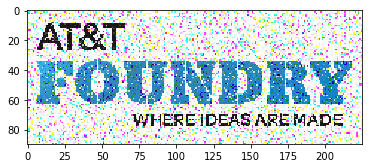

In [7]:
plt.imshow(receivedArray)